## Help Jesse Pinkman

The financially important reaction to produce the
valuable product B (not the real name) was carried out
in Jesse Pinkman’s garage (see *Breaking Bad* Season
3, Episode 7). This Breaking Bad, fly-by-night
company, is on a shoestring budget and has very little
money to purchase equipment. Fortunately, cousin
Bernie has a reactor surplus company and you can get
reactors from Bernie. The reaction

$$A \rightarrow B + C $$

takes place in the liquid phase. You have up to $10,000 to use to purchase reactors from those given below.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.optimize import fsolve
from scipy.integrate import quad

# Cousin Bernie's Reactor
CBR = pd.DataFrame({"Reactor Type" : ["CSTR", "CSTR", "PFR", "CSTR", "CSTR", "PFR"],
                    "Number": [2, 1, 2, 2, 3, 2],
                    "Volume (dm3)": [2, 4, 4, 6, 12, 12],
                    "Cost ($)": [1000, 2000, 2000, 4000, 8000, 6000]})

CBR

,Reactor Type,Number,Volume (dm3),Cost ($)
0,CSTR,2,2,1000
1,CSTR,1,4,2000
2,PFR,2,4,2000
3,CSTR,2,6,4000
4,CSTR,3,12,8000
5,PFR,2,12,6000


Below is the Levenspiel plot
for this reaction

Text(0.5,1,'Levenspiel Plot')

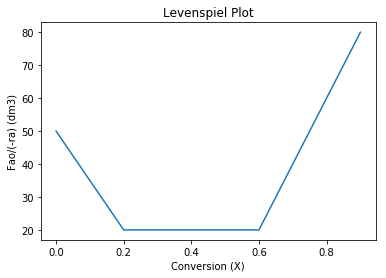

In [3]:
data = pd.DataFrame({"Fao/(-ra)": [50, 35, 20, 20, 20, 20, 20, 40, 60, 80],
                    "X": np.linspace(0, 0.9, 10)})

plt.plot(data["X"], data["Fao/(-ra)"])
plt.xlabel("Conversion (X)")
plt.ylabel("Fao/(-ra) (dm3)")
plt.title("Levenspiel Plot")

In [104]:
def ra(X):
    
    if X >= 0 and X <=0.2:
        # Use a linear regression to estimate the line on this region
        ra = -150*X + 50
    elif X > 0.2 and X <=0.6:
        ra = 20
    elif X > 0.6 and X <=0.9:
        # Use a linear regression to estimate the line on this region
        ra = 200*X - 100
    else:
        print("reaction rate data is not available")
    
    return ra

Text(0.5,1,'Levenspiel Plot')

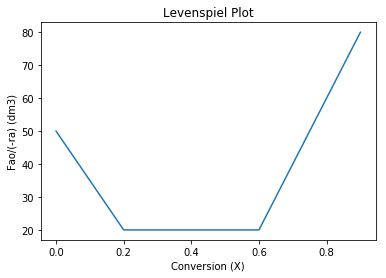

In [24]:
X = np.linspace(0,0.9,100)
ra_X = np.vectorize(ra)(X)

plt.plot(X,ra_X)
plt.xlabel("Conversion (X)")
plt.ylabel("Fao/(-ra) (dm3)")
plt.title("Levenspiel Plot")

What reactors do you choose, how do you arrange them, and
what is the highest conversion you can get for $10,000?
Approximately what is the corresponding highest conversion
with your arrangement of reactors?

To find the best arrangement of reactors, we will create functions that estimate the final conversion for both CSTR and PFR given the initial conversion, the reaction rate (as a function of conversion) and reactor volume.

For better guidance, here is a small step-by-step guidance on how to solve the equations.

1. Assume a value for the conversion at the exit of the reactor (Xout).

2. Use the design equations to calculate the reactor volume. <br>
2a. CSTR: Algebraic equation, calculate volume directly. <br>
2b. PFR: differential equation, use numerical integration to find volume. see *quad* method from SciPy library. <br>

3. Compare the calculated reactor volume with the given volume.

4. Iterate Xout until the calculated volume is equal to the given volume.
There are several methods available to run these iterations, i use the *fsolve* method from SciPy library.
 

## CSTR

In [26]:
def Vol_CSTR(Xin, Xout, Fa0_ra):
    return Fa0_ra(Xout)*(Xout - Xin)

def Xout_CSTR_eq(Xout, *args):
    
    Xin, Fa0_ra, V = args
    
    F = Vol_CSTR(Xin, Xout, Fa0_ra) - V
    
    return F**2

def Xout_CSTR(Xin, Fa0_ra, V):
    Xout = fsolve(Xout_CSTR_eq, 0, args=(Xin, Fa0_ra, V))
    
    return Xout[0]

## PFR

In [27]:
def Vol_PFR(Xin, Xout, Fa0_ra):
    return quad(Fa0_ra, Xin, Xout)[0] 

def Xout_PFR_eq(Xout, *args):
    
    Xin, Fa0_ra, V = args
    
    F = Vol_PFR(Xin, Xout, Fa0_ra) - V
    
    return F**2

def Xout_PFR(Xin, Fa0_ra, V):
    Xout = fsolve(Xout_PFR_eq, 0, args=(Xin, Fa0_ra, V))
    
    return Xout[0]

Now that we can calculate the conversion at the reactor outlet of either CSTR or PFR reactor, we can test different reactor configurations and see which gives the highest conversion.

In [89]:
conversion = {}

## Case 1: PFR only

With $10,000, we can buy a 12L reactor and 2 4L reactors for a total of 20L in volume. For ideal PFR, only the final volume matters. So the final conversion can be calculated as: 

In [90]:
conversion["Case 1"] = Xout_PFR(0, ra, 20)
conversion["Case 1"]

0.74494897417863415

## Case 2: 12L CSTR followed by 4L 

In [91]:
conversion["Case 2"] = Xout_CSTR(Xout_CSTR(0, ra, 12), ra, 4)
conversion["Case 2"]

0.6999999999999994

## Case 3: 6L CSTR followed by 12L PFR

In [92]:
conversion["Case 3"] = Xout_PFR(Xout_CSTR(0, ra, 6), ra, 12)
conversion["Case 3"]

0.76457513097043006


## Case 4: 4L CSTR followed by 4L PFR followed by a 12L PFR

In [93]:
conversion["Case 4"] = Xout_PFR(Xout_CSTR(0, ra, 4), ra, 16)
conversion["Case 4"]

0.77080128007965709

## Case 5: 6L CSTR followed by 6L CSTR followed by a 4L PFR

In [94]:
conversion["Case 5"] = Xout_PFR(Xout_CSTR(Xout_CSTR(0, ra, 6), ra, 6), ra, 4)
conversion["Case 5"]

0.72360679774997871

## Analysis

We can continue testing different configurations looking for the highest conversion. However, it is best to analyze the shape of the reaction rate as a function of conversion. We will analyze by dividing the graph in three sections:

## 1. Section 1: 0 to 0.2

In this region $\frac {Fa0} {ra} $ descends from 50 to 20. The volume required for a CSTR is less than the PFR. This is clear when you compare the area under the curve vs the rectangle formed with height 20 (final $\frac {Fa0} {ra}$) and width 0.2 ($X_{out}$ - $X_{in})$.


In [82]:
print("CSTR Volume: {}L".format(Vol_CSTR(0, 0.2, ra)))

CSTR Volume: 4.0L


In [83]:
print("PFR Volume: {}L".format(Vol_PFR(0, 0.2, ra)))

PFR Volume: 7.0L


In [84]:
def plot_levenspiel_plot(Xin, Xout, Fa0_ra_out):

    conversion =  np.linspace(0, 0.9, 50)
    fa0_ra = []
    for x in conversion:
        fa0_ra.append(ra(x))

    data = pd.DataFrame({"Fao/(-ra)": fa0_ra,
                        "X": conversion})

    fig, ax = plt.subplots()

    ax.plot(data["X"], data["Fao/(-ra)"], label="")
    ax.set_xlabel("Conversion (X)")
    ax.set_ylabel("Fao/(-ra) (dm3)")
    ax.set_title("Levenspiel Plot")
    
    fa0_ra_sec = []
    x_sec = np.linspace(Xin, Xout, 10)
    
    for x in x_sec:
        fa0_ra_sec.append(ra(x))
        
    ax.fill_between(x_sec,fa0_ra_sec, color= "navy", alpha=0.3, label="PFR")
    ax.add_patch(Rectangle((Xin,0), (Xout - Xin), Fa0_ra_out, color="red" , alpha=0.1, label="CSTR"))
    ax.legend()



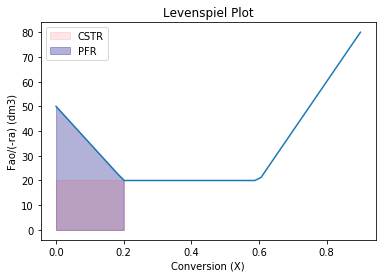

In [85]:
plot_levenspiel_plot(Xin=0, Xout=0.2, Fa0_ra_out=20)

## 2. Section 2: 0.2 to 0.6

In this region $\frac {Fa0} {ra} $ stays constant at 20. The reactor volume will be the same regardless whether it is a CSTR or PFR. 

In [50]:
Vol_CSTR(0.2, 0.6, ra)

7.999999999999999

In [51]:
Vol_PFR(0.2, 0.6, ra)

7.999999999999999

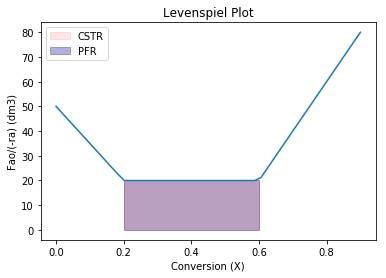

In [86]:
plot_levenspiel_plot(Xin=0.2, Xout=0.6, Fa0_ra_out=20)

## 3. Section 3: 0.6 to 0.9

In this region $\frac {Fa0} {ra} $ increases steadily from 20 to 80. Hence the smallest reactor will be a PFR as the area under the curve will be always smaller to the rectangle (or series of rentagles) formed with height $\frac {Fa0} {ra} $ that increases with conversion. 

In [52]:
Vol_CSTR(0.6, 0.9, ra)

24.000000000000004

In [53]:
Vol_PFR(0.6, 0.9, ra)

15.000000000000002

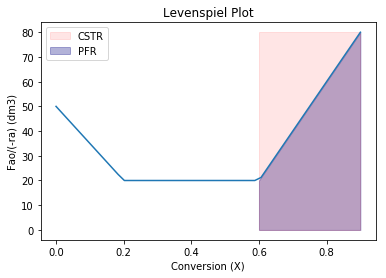

In [87]:
plot_levenspiel_plot(Xin=0.6, Xout=0.9, Fa0_ra_out=80)

## Conclusion

The highest reaction is attained with a combination of a CSTR reactor until reaching a conversion of 0.2. Then use a PFR (or series of PFR) until reaching the maximum conversion. Based on this, the highest attainable conversion with the cost limitation will be Case 4, 4L CSTR followed by a 4L PFR and a 12L PFR.

In [103]:
print("Maximum conversion rate: {:4f}".format(conversion["Case 4"]))

Maximum conversion rate: 0.770801
